In [6]:
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database, filter_data
reactions_clean = load_database('../Data/reaction_clean.json.gz')
filtered_data = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], formula_key='Diff_formula', element_key='C', min_count=1, max_count=10)
len(filtered_data)


13243

In [116]:
from rdkit import Chem
from rdkit.Chem import Draw

def draw_molecule_with_atom_indices(mol):
    """
    Draws a molecule with atom indices.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol): The molecule to be drawn.

    Returns:
    PIL.Image: An image of the molecule with atom indices.
    """
    # Create a copy of the molecule
    mol_with_atom_index = Chem.Mol(mol)

    # Use the MolDraw2D module to draw the molecule
    drawer = Draw.MolDraw2DCairo(300, 300)  # Adjust size as needed

    # Annotate atom indices
    for atom in mol_with_atom_index.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    # Draw the molecule
    drawer.DrawMolecule(mol_with_atom_index)
    drawer.FinishDrawing()

    # Convert the drawing to an image
    image = drawer.GetDrawingText()
    return Chem.Draw.Image.open(io.BytesIO(image))


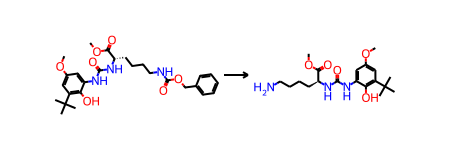

In [153]:
from rdkit.Chem import AllChem, rdChemReactions
def display_reaction(reaction_dict, index, reaction_key ='reactions', use_smiles = True):
    return display(rdChemReactions.ReactionFromSmarts(reaction_dict[index][reaction_key], useSmiles= use_smiles))
display_reaction(filtered_data, 0)

In [155]:
test = filtered_data[0]
test

{'id': 'US05849732',
 'class': 6,
 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 8, 'O': 2, 'H': 6}}

In [156]:
from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
analyzer = MCSMissingGraphAnalyzer()
mcs_list, missing_part_reactant, missing_part_product, reactant_mol_list, product_mol_list = analyzer.fit(test, curate_radicals=True)

In [132]:
from rdkit import Chem
from rdkit.Chem import Draw
import io
from PIL import Image

def draw_molecule_with_atom_indices(mol):
    """
    Draws a molecule with atom indices.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol): The molecule to be drawn.

    Returns:
    PIL.Image: An image of the molecule with atom indices.
    """
    # Create a copy of the molecule
    mol_with_atom_index = Chem.Mol(mol)

    # Use the MolDraw2D module to draw the molecule
    drawer = Draw.MolDraw2DCairo(300, 300)  # Adjust size as needed

    # Annotate atom indices
    for atom in mol_with_atom_index.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    # Draw the molecule
    drawer.DrawMolecule(mol_with_atom_index)
    drawer.FinishDrawing()

    # Convert the drawing to an image
    image = drawer.GetDrawingText()
    return Image.open(io.BytesIO(image))




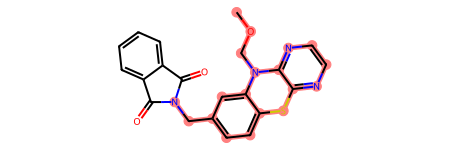

In [133]:
reactant_mol_list[0]

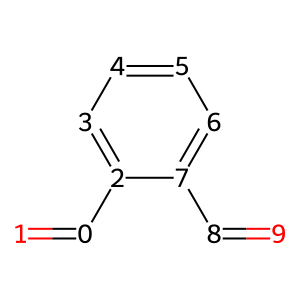

In [134]:
draw_molecule_with_atom_indices(missing_part_reactant[0])

In [157]:
from rdkit import Chem
from rdkit.Chem import Draw

class MolecularConnectivity:
    @staticmethod
    def find_boundary_atoms(original_mol_list, missing_mol_list, visualize_substructure=False):
        boundary_atoms_list = []
        nearest_neighbor_list = []

        for missing_idx, missing_mol in enumerate(missing_mol_list):
            
            boundary_atoms = {}
            nearest_atoms = []
            for original_idx, original_mol in enumerate(original_mol_list):
                substructure_match = original_mol.GetSubstructMatch(missing_mol)
                
                if substructure_match:
                    if visualize_substructure:
                        highlight = Chem.MolFromSmarts(Chem.MolToSmarts(missing_mol))
                        Chem.SanitizeMol(original_mol)
                        Chem.SanitizeMol(highlight)
                        Draw.MolToImage(original_mol, highlightAtoms=list(substructure_match))
                    
                    boundary_atoms[original_idx] = []
                    for atom_idx in substructure_match:
                        if atom_idx < original_mol.GetNumAtoms():
                            atom_symbol = original_mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = original_mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({neighbor.GetSymbol(): neighbor.GetIdx()})
                                    #print(atom_idx)
                                    renumerate_idx = atom_idx - substructure_match[0]
                                    #print(renumerate_idx)
                                    boundary_atoms[original_idx].append((atom_symbol, renumerate_idx))
                                    #break
            
            if boundary_atoms:
                boundary_atoms_list.append(boundary_atoms)
            if nearest_atoms:
                nearest_neighbor_list.append(nearest_atoms)
        
        return boundary_atoms_list, nearest_neighbor_list

    @staticmethod
    def convert_to_atom_index_dict(converted_boundary_atoms_list):
        result_list = []

        for item_dict in converted_boundary_atoms_list:
            for key, value in item_dict.items():
                result_dict = {value[0][0]: value[0][1]}
                result_list.append(result_dict)

        return result_list
    
    @staticmethod
    def convert_structure(input_list):
        """
        Converts a list of dictionaries with tuples to a list of lists containing dictionaries.

        Parameters:
        input_list (list): A list of dictionaries, where each dictionary contains key-value pairs, 
                        and the value is a list of tuples.

        Returns:
        list: A list of lists, where each inner list contains dictionaries with data from the tuples.
        """
        return [[{atom: idx} for atom, idx in value] for dictionary in input_list for key, value in dictionary.items()]

   



In [148]:
def convert_structure(input_list):
    """
    Converts a list of dictionaries with tuples to a list of lists containing dictionaries.

    Parameters:
    input_list (list): A list of dictionaries, where each dictionary contains key-value pairs, 
                    and the value is a list of tuples.

    Returns:
    list: A list of lists, where each inner list contains dictionaries with data from the tuples.
    """
    return [[{atom: idx} for atom, idx in value] for dictionary in input_list for key, value in dictionary.items()]


In [146]:
input_list = [{0: [('C', 0), ('C', 8)]}]
converted_list = convert_structure(input_list)
converted_list

[[{'C': 0}, {'C': 8}]]

In [122]:
from rdkit import Chem
from rdkit.Chem import Draw

class MolecularConnectivity:
    """
    This class provides functionalities for analyzing the connectivity and boundary atoms
    in molecular structures using RDKit.

    Methods:
    find_boundary_atoms: Identifies and optionally visualizes the boundary atoms in a set of 
                         molecules relative to a set of substructures.
    convert_to_atom_index_dict: Converts the boundary atoms information to a dictionary format.
    """

    @staticmethod
    def find_boundary_atoms(original_mol_list, missing_mol_list, visualize_substructure=False):
        """
        Identifies boundary atoms in molecules and optionally visualizes the substructures.

        Parameters:
        original_mol_list (list of rdkit.Chem.rdchem.Mol): List of original molecules.
        missing_mol_list (list of rdkit.Chem.rdchem.Mol): List of substructure molecules to find in the original molecules.
        visualize_substructure (bool, optional): If True, visualizes the matched substructure in the original molecules.

        Returns:
        tuple: A tuple containing two lists:
            - boundary_atoms_list: A list of dictionaries. Each dictionary maps an index in original_mol_list to a list of tuples, 
                                   each tuple representing a boundary atom's symbol and a renumerated index.
            - nearest_neighbor_list: A list of dictionaries, each containing the symbol and index of the nearest neighbor atom 
                                     not in the substructure match.

        Notes:
        - This method identifies boundary atoms in each original molecule that correspond to the substructures defined in missing_mol_list.
        - If visualize_substructure is True, images of the original molecules with highlighted substructures are generated.
        """
        # Method implementation
        ...

    @staticmethod
    def convert_to_atom_index_dict(converted_boundary_atoms_list):
        """
        Converts a list of dictionaries containing boundary atoms information to a specific dictionary format.

        Parameters:
        converted_boundary_atoms_list (list of dict): List of dictionaries containing boundary atom information.

        Returns:
        list of dict: List of dictionaries, each mapping the symbol of a boundary atom to its renumerated index.

        Notes:
        - This method is typically used to reformat the output of find_boundary_atoms for further processing or analysis.
        """
        # Method implementation
        ...


In [158]:
connect = MolecularConnectivity()

boundary_atoms_list, nearest_neighbor_list=connect.find_boundary_atoms(original_mol_list= reactant_mol_list, missing_mol_list=missing_part_reactant, visualize_substructure=True)
print(connect.convert_structure(boundary_atoms_list))
print('nearest_neighbor_list:',nearest_neighbor_list)



[[{'C': 0}]]
nearest_neighbor_list: [[{'N': 9}]]


In [147]:
boundary_atoms_list

[{0: [('C', 0), ('C', 8)]}]

In [140]:
boundary_atoms_list

[{0: [('C', 0), ('C', 8)]}]

In [138]:
boundary_atoms_list

[{0: [('C', 0), ('C', 8)]}]

In [ ]:
[[{'C': 0}, {'C': 8}]]

In [51]:
def draw_molecule(mol):
    return display(Draw.MolToImage(mol))

In [93]:
def test_case(data, index, display = True):
    if display:
        display_reaction(data, index)
    test = data[index]
    analyzer = MCSMissingGraphAnalyzer()
    mcs_list, missing_part_reactant, missing_part_product, reactant_mol_list, product_mol_list = analyzer.fit(test, curate_radicals=True)
    for i in mcs_list:
        draw_molecule(i)
    missing_part_reactant = [element for element in missing_part_reactant if element is not None]
    missing_part_product = [element for element in missing_part_product if element is not None]
    
   
    if len(missing_part_reactant)>0:
        print('MISSING IN REACTANTS:')
        for i in missing_part_reactant:
            draw_molecule(i)
        connect = MolecularConnectivity()

        boundary_atoms_list, nearest_neighbor_list=connect.find_boundary_atoms(original_mol_list= reactant_mol_list, missing_mol_list=missing_part_reactant, visualize_substructure=True)
        print(connect.convert_to_atom_index_dict(boundary_atoms_list))
        print('nearest_neighbor_list:',nearest_neighbor_list)
    else:
         print('NO MISSING IN REACTANTS:')




    if len(missing_part_product)>0:
        print('MISSING IN PRODUCTS:')
        for i in missing_part_product:
            draw_molecule(i)
        connect = MolecularConnectivity()

        boundary_atoms_list, nearest_neighbor_list=connect.find_boundary_atoms(original_mol_list= product_mol_list, missing_mol_list=missing_part_product, visualize_substructure=True)
        print(connect.convert_to_atom_index_dict(boundary_atoms_list))
        print('nearest_neighbor_list:',nearest_neighbor_list)

    else:
        print('NO MISSING IN PRODUCTS:')


    

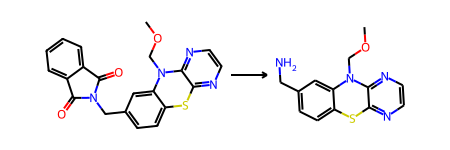

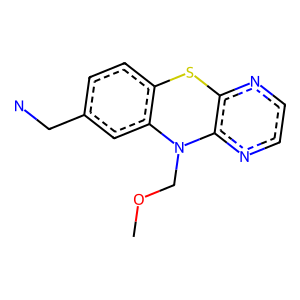

MISSING IN REACTANTS:


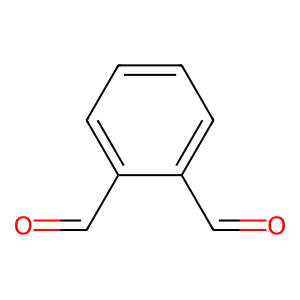

[{'C': 0}]
nearest_neighbor_list: [{'N': 8}, {'N': 8}]
NO MISSING IN PRODUCTS:


In [108]:
test_case(filtered_data, 48, display = True)